### Import librairies

In [1]:
# Main libraries
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager

# Libraries for vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Library for ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [52]:
# Show exact values on barplots
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

### Import pre-processed dataset

In [2]:
train_df_nan40 = pd.read_csv('train_df_nan40.csv')

In [3]:
# remove special characters in train_df_nan40 feature names
train_df_nan40.columns = train_df_nan40.columns.str.replace(':', '')
train_df_nan40.columns = train_df_nan40.columns.str.replace(',', '')
train_df_nan40.columns = train_df_nan40.columns.str.replace(']', '')
train_df_nan40.columns = train_df_nan40.columns.str.replace('[', '')
train_df_nan40.columns = train_df_nan40.columns.str.replace('{', '')
train_df_nan40.columns = train_df_nan40.columns.str.replace('}', '')
train_df_nan40.columns = train_df_nan40.columns.str.replace('"', '')

# Create and evaluate classification models

### Evaluate DummyClassifier

In [4]:
# Import necessary functions
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [5]:
# Create X (features matrix) and y (Target) from train_df_nan40
X = train_df_nan40.drop(['index', 'SK_ID_CURR', 'TARGET'], 1)
y = train_df_nan40.TARGET

In [6]:
# Create DummyClassifier with 'most_frequent' strategy
dummy_clf = DummyClassifier(strategy = 'most_frequent')
# Define cross validation strategy
cv = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)
# Define scoring strategy
scoring = ('accuracy', 'f1_weighted', 'roc_auc')
# Evaluate accuracy, AUC and f1 scores after cross validation
scores = cross_validate(dummy_clf, 
                        X, y, 
                        cv = cv,
                        scoring = scoring)

# Print test scores and mean scores for each metric
list_scoring = ['test_accuracy', 'test_f1_weighted', 'test_roc_auc']
for score in list_scoring:
    print(f'{score} scores')
    print(scores[score])
    print(f'{score} mean score')
    print(round(scores[score].mean(), 3))
    print('------------')

test_accuracy scores
[0.91927092 0.91927092 0.91926961 0.91926961 0.91926961]
test_accuracy mean score
0.919
------------
test_f1_weighted scores
[0.88060421 0.88060421 0.88060229 0.88060229 0.88060229]
test_f1_weighted mean score
0.881
------------
test_roc_auc scores
[0.5 0.5 0.5 0.5 0.5]
test_roc_auc mean score
0.5
------------


-> accuracy mean score = 0.919 just means that the majority class represents 91.9% of the whole dataset
-> roc_auc mean score = 0.5 corresponds to the score of a random classifier

In [7]:
# Create DummyClassifier with 'stratified' strategy
dummy_clf = DummyClassifier(strategy = 'stratified')
# Define cv strategy
cv = StratifiedKFold(n_splits = 5, random_state = 1, shuffle = True)
# Define scoring strategy
scoring = ('accuracy', 'f1_weighted', 'roc_auc')
# Evaluate accuracy, AUC and f1 scores after cross validation
scores = cross_validate(dummy_clf, 
                        X, y, 
                        cv = cv,
                        scoring = scoring)

# Print test scores and mean scores for each metric
list_scoring = ['test_accuracy', 'test_f1_weighted', 'test_roc_auc']
for score in list_scoring:
    print(f'{score} scores')
    print(scores[score])
    print(f'{score} mean score')
    print(round(scores[score].mean(), 3))
    print('------------')

test_accuracy scores
[0.85115931 0.85161458 0.85250646 0.85109185 0.85060406]
test_accuracy mean score
0.851
------------
test_f1_weighted scores
[0.85089843 0.85140943 0.8526484  0.85114652 0.85091809]
test_f1_weighted mean score
0.851
------------
test_roc_auc scores
[0.49866435 0.4998129  0.49772107 0.49811847 0.49834925]
test_roc_auc mean score
0.499
------------


-> roc_auc mean score = 0.499 corresponds to the score of a random classifier

-> Other classifiers will be evaluated using roc_auc scores

### SGDClassifier

In [8]:
# SGD Classifier with scaler/classifier pipeline (no oversampling)
# Using default parameters
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', SGDClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_sgdc_default = GridSearchCV(estimator = pipeline,
                               param_grid = param_grid,
                               scoring = 'roc_auc',
                               cv = stratified_kfold,
                               verbose = 5,
                               return_train_score = True)


gs_sgdc_default.fit(X, y)

cv_score_sgdc_default = gs_sgdc_default.best_score_
print('cv_score_sgdc_default:', cv_score_sgdc_default)

cv_results_sgdc_default = gs_sgdc_default.cv_results_
df_sgdc_default = pd.DataFrame(cv_results_sgdc_default)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.663, test=0.658) total time= 1.3min
[CV 2/5] END ..............., score=(train=0.672, test=0.667) total time=  22.5s
[CV 3/5] END ..............., score=(train=0.671, test=0.674) total time=  26.2s
[CV 4/5] END ..............., score=(train=0.669, test=0.664) total time=  21.1s
[CV 5/5] END ..............., score=(train=0.659, test=0.664) total time=  23.2s
cv_score_lgbm: 0.665507676587798
Execution time in seconds: 206.40424728393555
Execution time in minutes: 3.4400707880655923


In [12]:
# SGD Classifier with scaler/classifier pipeline (no oversampling)
# Testing parameters with gridsearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', SGDClassifier()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Testing different parameters
param_grid = {'classifier__alpha': [1e-4, 1e-2, 1e0, 1e2], # learning rate
              'classifier__max_iter': [1000], # number of epochs,
              'classifier__loss': ['hinge', 'log'], # linear SVM or logistic regression,
              'classifier__penalty': ['l2']}

gs_sgdc = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = 'roc_auc',
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)


gs_sgdc.fit(X, y)

cv_score_sgdc = gs_sgdc.best_score_
print('cv_score_sgdc:', cv_score_sgdc)

cv_results_sgdc = gs_sgdc.cv_results_
df_sgdc = pd.DataFrame(cv_results_sgdc)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2;, score=(train=0.645, test=0.646) total time=  22.9s
[CV 2/5] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2;, score=(train=0.688, test=0.686) total time=  33.3s
[CV 3/5] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2;, score=(train=0.667, test=0.664) total time=  20.5s
[CV 4/5] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2;, score=(train=0.658, test=0.650) total time=  21.4s
[CV 5/5] END classifier__alpha=0.0001, classifier__loss=hinge, classifier__max_iter=1000, classifier__penalty=l2;, score=(train=0.657, test=0.654) total time=  18.1s
[CV 1/5] END classifier__alpha=0.0001, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2

In [14]:
# Compare loss params : hinge (linearSVM) and log(logistic regression)
df_sgdc.groupby('param_classifier__loss')['mean_test_score'].mean()

param_classifier__loss
hinge    0.693008
log      0.733115
Name: mean_test_score, dtype: float64

-> Logistic regression results in better roc_auc scores

In [19]:
# Sort results by mean_test_score in df_sgdc
df_sgdc.sort_values(by = 'mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__loss,param_classifier__max_iter,param_classifier__penalty,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,21.769146,9.813351,0.465238,0.152395,0.01,log,1000,l2,"{'classifier__alpha': 0.01, 'classifier__loss'...",0.764517,...,0.763364,0.001704,1,0.769062,0.768191,0.767918,0.768153,0.768259,0.768316,0.000390
1,19.686957,3.812885,0.418668,0.075504,0.0001,log,1000,l2,"{'classifier__alpha': 0.0001, 'classifier__los...",0.751428,...,0.744100,0.003717,2,0.756864,0.745054,0.746666,0.745915,0.751584,0.749217,0.004446
5,8.295024,0.453398,0.622081,0.214608,1.0,log,1000,l2,"{'classifier__alpha': 1.0, 'classifier__loss':...",0.720581,...,0.722398,0.001533,3,0.721814,0.722815,0.722291,0.724871,0.727825,0.723923,0.002212
4,14.970112,4.955132,0.694214,0.303806,1.0,hinge,1000,l2,"{'classifier__alpha': 1.0, 'classifier__loss':...",0.754995,...,0.720236,0.018813,4,0.760214,0.708963,0.708457,0.704915,0.729412,0.722392,0.020783
7,7.162304,0.242792,0.402341,0.059074,100.0,log,1000,l2,"{'classifier__alpha': 100.0, 'classifier__loss...",0.703053,...,0.702599,0.001612,5,0.703664,0.703395,0.703431,0.703678,0.704082,0.703650,0.000245
6,12.366454,2.819907,0.828855,0.732299,100.0,hinge,1000,l2,"{'classifier__alpha': 100.0, 'classifier__loss...",0.702055,...,0.701638,0.001611,6,0.702657,0.702442,0.702441,0.702716,0.703096,0.702671,0.000240
2,24.294172,14.536203,0.524458,0.195153,0.01,hinge,1000,l2,"{'classifier__alpha': 0.01, 'classifier__loss'...",0.688977,...,0.690103,0.033700,7,0.691822,0.759005,0.682961,0.666758,0.667529,0.693615,0.034042
0,21.766879,3.293911,1.579971,2.132744,0.0001,hinge,1000,l2,"{'classifier__alpha': 0.0001, 'classifier__los...",0.646323,...,0.660054,0.014147,8,0.644515,0.688343,0.667357,0.658472,0.657350,0.663207,0.014527


In [16]:
# Print the best parameters
gs_sgdc.best_params_

{'classifier__alpha': 0.01,
 'classifier__loss': 'log',
 'classifier__max_iter': 1000,
 'classifier__penalty': 'l2'}

-> Those parameters will be used with SMOTE oversampling in the pipeline

In [43]:
# SGD Classifier with smote/scaler/classifier pipeline (oversampling)
# Testing smote parameters with gridsearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline) with smote, scaler and classifier steps
# imbpipeline automatically skip the sampling method (smote) when predict is called
# -> Consequently, there is no data leakage
pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', SGDClassifier()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Testing different parameters
param_grid = {'smote__sampling_strategy' : [0.25, 0.5, 1],
              'classifier__alpha': [1e-2], # learning rate
              'classifier__max_iter': [1000], # number of epochs,
              'classifier__loss': ['log'], # linear SVM or logistic regression,
              'classifier__penalty': ['l2']}

gs_sgdc_smote = GridSearchCV(estimator = pipeline,
                             param_grid = param_grid,
                             scoring = 'roc_auc',
                             cv = stratified_kfold,
                             verbose = 5,
                             return_train_score = True)

gs_sgdc_smote.fit(X, y)

cv_score_sgdc_smote = gs_sgdc_smote.best_score_
print('cv_score_sgdc_smote:', cv_score_sgdc_smote)

cv_results_sgdc_smote = gs_sgdc_smote.cv_results_
df_sgdc_smote = pd.DataFrame(cv_results_sgdc_smote)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END classifier__alpha=0.01, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2, smote__sampling_strategy=0.25;, score=(train=0.755, test=0.751) total time=  36.0s
[CV 2/5] END classifier__alpha=0.01, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2, smote__sampling_strategy=0.25;, score=(train=0.755, test=0.753) total time=  36.8s
[CV 3/5] END classifier__alpha=0.01, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2, smote__sampling_strategy=0.25;, score=(train=0.755, test=0.752) total time=  35.2s
[CV 4/5] END classifier__alpha=0.01, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2, smote__sampling_strategy=0.25;, score=(train=0.756, test=0.749) total time=  33.9s
[CV 5/5] END classifier__alpha=0.01, classifier__loss=log, classifier__max_iter=1000, classifier__penalty=l2, smote__sampling_strategy=0.25;, score=(train=0.757, test=0

In [44]:
# Sort results by mean_test_score in df_sgdc_smote
df_sgdc_smote.sort_values(by = 'mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__loss,param_classifier__max_iter,param_classifier__penalty,param_smote__sampling_strategy,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,34.792451,1.001144,0.616272,0.124436,0.01,log,1000,l2,0.25,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.751240,0.001264,1,0.755331,0.755175,0.755476,0.755935,0.756684,0.755720,0.000545
1,38.165315,3.879312,0.749596,0.343286,0.01,log,1000,l2,0.5,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.743208,0.001667,2,0.747575,0.747377,0.747551,0.747856,0.747710,0.747614,0.000161
2,51.489682,4.364350,1.192805,0.339977,0.01,log,1000,l2,1,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.732377,0.001276,3,0.737048,0.734762,0.737636,0.737287,0.736520,0.736650,0.001012


In [45]:
# Keep only best results in df_sgdc
df_sgdc_best_results = df_sgdc.sort_values(by = 'mean_test_score', ascending = False).head(1)

# Concatenate df_sgdc_smote with best results in df_sgdc (without smote)
df_sgdc_smote = pd.concat([df_sgdc_smote, df_sgdc_best_results], axis = 0)

In [46]:
# Sort by 'mean_test_score'
df_sgdc_smote.sort_values(by = 'mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__loss,param_classifier__max_iter,param_classifier__penalty,param_smote__sampling_strategy,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,21.769146,9.813351,0.465238,0.152395,0.01,log,1000,l2,NaN,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.763364,0.001704,1,0.769062,0.768191,0.767918,0.768153,0.768259,0.768316,0.000390
0,34.792451,1.001144,0.616272,0.124436,0.01,log,1000,l2,0.25,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.751240,0.001264,1,0.755331,0.755175,0.755476,0.755935,0.756684,0.755720,0.000545
1,38.165315,3.879312,0.749596,0.343286,0.01,log,1000,l2,0.5,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.743208,0.001667,2,0.747575,0.747377,0.747551,0.747856,0.747710,0.747614,0.000161
2,51.489682,4.364350,1.192805,0.339977,0.01,log,1000,l2,1,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.732377,0.001276,3,0.737048,0.734762,0.737636,0.737287,0.736520,0.736650,0.001012


In [47]:
df_sgdc_smote['param_smote__sampling_strategy'] = df_sgdc_smote['param_smote__sampling_strategy'].fillna('None')

In [48]:
df_sgdc_smote

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__loss,param_classifier__max_iter,param_classifier__penalty,param_smote__sampling_strategy,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,34.792451,1.001144,0.616272,0.124436,0.01,log,1000,l2,0.25,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.751240,0.001264,1,0.755331,0.755175,0.755476,0.755935,0.756684,0.755720,0.000545
1,38.165315,3.879312,0.749596,0.343286,0.01,log,1000,l2,0.5,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.743208,0.001667,2,0.747575,0.747377,0.747551,0.747856,0.747710,0.747614,0.000161
2,51.489682,4.364350,1.192805,0.339977,0.01,log,1000,l2,1,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.732377,0.001276,3,0.737048,0.734762,0.737636,0.737287,0.736520,0.736650,0.001012
3,21.769146,9.813351,0.465238,0.152395,0.01,log,1000,l2,None,"{'classifier__alpha': 0.01, 'classifier__loss'...",...,0.763364,0.001704,1,0.769062,0.768191,0.767918,0.768153,0.768259,0.768316,0.000390


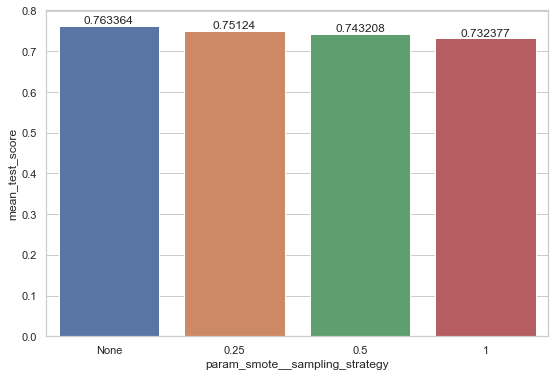

In [55]:
# Plot mean test scores by param_smote__sampling_strategy
import seaborn as sns

plt.figure(figsize=(9, 6))

sns.set_theme(style="whitegrid")

g = sns.barplot(x = 'param_smote__sampling_strategy',
                y = 'mean_test_score',
                data = df_sgdc_smote,
                order = ['None', 0.25, 0.5, 1])

# Show exact mean_test_score for each sampling strategy
for i in g.containers:
    g.bar_label(i,)

plt.show()

### Conclusions for SGD Classifier
- best parameters found by GridSearchCV are alpha = 0.01 and loss = log
- oversampling the minority class with SMOTE disimproves the mean test scores

### Logistic Regression

In [57]:
# Logistic Regression with scaler/classifier pipeline (no oversampling)
# Using default parameters
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LogisticRegression(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {}

gs_lr_default = GridSearchCV(estimator = pipeline,
                             param_grid = param_grid,
                             scoring = 'roc_auc',
                             cv = stratified_kfold,
                             verbose = 5,
                             return_train_score = True)


gs_lr_default.fit(X, y)

cv_score_lr_default = gs_lr_default.best_score_
print('cv_score_lr_default:', cv_score_lr_default)

cv_results_lr_default = gs_lr_default.cv_results_
df_lr_default = pd.DataFrame(cv_results_lr_default)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ..............., score=(train=0.773, test=0.768) total time=  41.0s
[CV 2/5] END ..............., score=(train=0.773, test=0.769) total time=  43.9s
[CV 3/5] END ..............., score=(train=0.773, test=0.768) total time=  34.2s
[CV 4/5] END ..............., score=(train=0.773, test=0.766) total time=  31.7s
[CV 5/5] END ..............., score=(train=0.773, test=0.765) total time=  29.6s
cv_score_lr_default: 0.7671036824949046
Execution time in seconds: 239.43307614326477
Execution time in minutes: 3.990551269054413


In [ ]:
# Logistic Regression with scaler/classifier pipeline (no oversampling)
# Testing different parameters with gridsearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

startFitTime = time.time()

# Create pipeline (imbpipeline)
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LogisticRegression(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Using default parameters
param_grid = {'classifier__penalty': ['l2', 'none'],
              'classifier__C': [0.1, 1, 10],
              'classifier__solver': ['lbfgs']}

gs_lr = GridSearchCV(estimator = pipeline,
                             param_grid = param_grid,
                             scoring = 'roc_auc',
                             cv = stratified_kfold,
                             verbose = 5,
                             return_train_score = True)


gs_lr.fit(X, y)

cv_score_lr = gs_lr.best_score_
print('cv_score_lr:', cv_score_lr)

cv_results_lr = gs_lr.cv_results_
df_lr = pd.DataFrame(cv_results_lr)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Create pipeline (imbpipeline) with smote, scaler and classifier steps
# imbpipeline automatically skip the sampling method (smote) when predict is called
# -> Consequently, there is no data leakage
pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy' : [1],
              'classifier__n_estimators' : [500]}

gs_lgbm = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = 'roc_auc',
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)

startFitTime = time.time()
gs_lgbm.fit(X, y)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score_lgbm = gs_lgbm.best_score_
print('cv_score_lgbm:', cv_score_lgbm)

cv_results_lgbm = gs_lgbm.cv_results_
df_lgbmc = pd.DataFrame(cv_results_lgbm)
df_lgbmc

### Evaluate lgbm Classifier

In [63]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Create pipeline (imbpipeline) with smote, scaler and classifier steps
# imbpipeline automatically skip the sampling method (smote) when predict is called
# -> Consequently, there is no data leakage
pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy' : [1],
              'classifier__n_estimators' : [500]}

gs_lgbm = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = 'roc_auc',
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)

startFitTime = time.time()
gs_lgbm.fit(X, y)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score_lgbm = gs_lgbm.best_score_
print('cv_score_lgbm:', cv_score_lgbm)

cv_results_lgbm = gs_lgbm.cv_results_
df_lgbmc = pd.DataFrame(cv_results_lgbm)
df_lgbmc

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__n_estimators=500, smote__sampling_strategy=1;, score=(train=0.921, test=0.772) total time= 1.9min
[CV 2/5] END classifier__n_estimators=500, smote__sampling_strategy=1;, score=(train=0.919, test=0.775) total time= 1.7min
[CV 3/5] END classifier__n_estimators=500, smote__sampling_strategy=1;, score=(train=0.920, test=0.774) total time= 1.6min
[CV 4/5] END classifier__n_estimators=500, smote__sampling_strategy=1;, score=(train=0.919, test=0.769) total time= 1.9min
[CV 5/5] END classifier__n_estimators=500, smote__sampling_strategy=1;, score=(train=0.922, test=0.769) total time= 1.8min
Execution time in seconds: 691.981338262558
Execution time in minutes: 11.533022304375967
cv_score_lgbm: 0.7717708530587315


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,105.695742,5.148001,1.168862,0.03488,500,1,"{'classifier__n_estimators': 500, 'smote__sampling_strategy': 1}",0.771805,0.774772,0.774437,0.768953,0.768888,0.771771,0.002544,1,0.921223,0.91914,0.920365,0.919276,0.922141,0.920429,0.001145


In [96]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import collections

# Create pipeline (imbpipeline) with smote, scaler and classifier steps
# imbpipeline automatically skip the sampling method (smote) when predict is called
# -> Consequently, there is no data leakage
pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Define param_grid for GridSearchCV
param_grid = {'smote__sampling_strategy' : [0.25, 0.5, 1],
              'classifier__n_estimators' : [500, 1000, 2000],
              'classifier__num_leaves': [31, 50]}

# Create GridSearchCV model
gs_lgbm = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = 'roc_auc',
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)

startTime = time.time()
gs_lgbm.fit(X, y)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Execution time in minutes: ' + str(executionTime / 60))

cv_score_lgbm = gs_lgbm.best_score_
print('cv_score_lgbm:', cv_score_lgbm)

cv_results_lgbm = gs_lgbm.cv_results_
df_lgbmc = pd.DataFrame(cv_results_lgbm)
df_lgbmc

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END classifier__n_estimators=500, classifier__num_leaves=31, smote__sampling_strategy=0.25;, score=(train=0.924, test=0.773) total time= 1.1min
[CV 2/5] END classifier__n_estimators=500, classifier__num_leaves=31, smote__sampling_strategy=0.25;, score=(train=0.923, test=0.776) total time= 1.2min
[CV 3/5] END classifier__n_estimators=500, classifier__num_leaves=31, smote__sampling_strategy=0.25;, score=(train=0.925, test=0.777) total time= 1.1min
[CV 4/5] END classifier__n_estimators=500, classifier__num_leaves=31, smote__sampling_strategy=0.25;, score=(train=0.924, test=0.772) total time= 1.1min
[CV 5/5] END classifier__n_estimators=500, classifier__num_leaves=31, smote__sampling_strategy=0.25;, score=(train=0.925, test=0.771) total time= 1.1min
[CV 1/5] END classifier__n_estimators=500, classifier__num_leaves=31, smote__sampling_strategy=0.5;, score=(train=0.924, test=0.773) total time= 1.2min
[CV 2/5] END classifie

[CV 5/5] END classifier__n_estimators=1000, classifier__num_leaves=50, smote__sampling_strategy=0.5;, score=(train=0.996, test=0.763) total time= 2.1min
[CV 1/5] END classifier__n_estimators=1000, classifier__num_leaves=50, smote__sampling_strategy=1;, score=(train=0.996, test=0.768) total time= 2.7min
[CV 2/5] END classifier__n_estimators=1000, classifier__num_leaves=50, smote__sampling_strategy=1;, score=(train=0.996, test=0.771) total time= 2.6min
[CV 3/5] END classifier__n_estimators=1000, classifier__num_leaves=50, smote__sampling_strategy=1;, score=(train=0.996, test=0.770) total time= 2.6min
[CV 4/5] END classifier__n_estimators=1000, classifier__num_leaves=50, smote__sampling_strategy=1;, score=(train=0.995, test=0.766) total time= 2.7min
[CV 5/5] END classifier__n_estimators=1000, classifier__num_leaves=50, smote__sampling_strategy=1;, score=(train=0.996, test=0.763) total time= 2.6min
[CV 1/5] END classifier__n_estimators=2000, classifier__num_leaves=31, smote__sampling_strat

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__num_leaves,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,66.618199,2.164613,0.971173,0.020688,500,31,0.25,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 31, 'smote__sampling_strategy': 0.25}",0.773227,0.776018,0.777333,0.771847,0.771023,0.773890,0.002417,2,0.924462,0.923076,0.924853,0.923508,0.924685,0.924117,0.000698
1,74.674002,2.528774,0.990418,0.052328,500,31,0.5,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 31, 'smote__sampling_strategy': 0.5}",0.772564,0.775833,0.775728,0.770592,0.770485,0.773040,0.002357,3,0.924251,0.922251,0.922456,0.921741,0.922822,0.922704,0.000849
2,96.838054,5.120298,1.140891,0.040570,500,31,1,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 31, 'smote__sampling_strategy': 1}",0.771805,0.774772,0.774437,0.768953,0.768888,0.771771,0.002544,4,0.921223,0.919140,0.920365,0.919276,0.922141,0.920429,0.001145
3,72.202773,1.297574,1.110056,0.079992,500,50,0.25,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 50, 'smote__sampling_strategy': 0.25}",0.773792,0.777035,0.776821,0.772643,0.770777,0.774214,0.002417,1,0.966982,0.967604,0.965449,0.964916,0.967215,0.966433,0.001054
4,82.702158,1.752617,1.116846,0.103315,500,50,0.5,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 50, 'smote__sampling_strategy': 0.5}",0.770817,0.773637,0.771191,0.766868,0.767513,0.770005,0.002502,8,0.965464,0.963829,0.963960,0.963458,0.964823,0.964307,0.000731
5,111.616324,5.811772,1.298354,0.047061,500,50,1,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 50, 'smote__sampling_strategy': 1}",0.769581,0.774225,0.773546,0.768355,0.767114,0.770564,0.002830,6,0.963926,0.963878,0.963547,0.962341,0.964346,0.963608,0.000682
6,89.646433,2.136310,1.278153,0.081086,1000,31,0.25,"{'classifier__n_estimators': 1000, 'classifier__num_leaves': 31, 'smote__sampling_strategy': 0.25}",0.772308,0.773723,0.774872,0.769631,0.768025,0.771712,0.002542,5,0.976790,0.975762,0.976489,0.976124,0.976244,0.976282,0.000346
7,106.547439,2.476292,1.380771,0.111980,1000,31,0.5,"{'classifier__n_estimators': 1000, 'classifier__num_leaves': 31, 'smote__sampling_strategy': 0.5}",0.770759,0.772584,0.773297,0.767388,0.767811,0.770368,0.002411,7,0.976743,0.975768,0.976403,0.974750,0.976726,0.976078,0.000752
8,129.871383,3.644784,1.476653,0.047398,1000,31,1,"{'classifier__n_estimators': 1000, 'classifier__num_leaves': 31, 'smote__sampling_strategy': 1}",0.770956,0.772990,0.771966,0.765887,0.766391,0.769638,0.002933,10,0.975636,0.974493,0.975060,0.973956,0.975727,0.974975,0.000675
9,506.298771,802.695461,1.427299,0.133539,1000,50,0.25,"{'classifier__n_estimators': 1000, 'classifier__num_leaves': 50, 'smote__sampling_strategy': 0.25}",0.769700,0.771081,0.773512,0.768467,0.765936,0.769739,0.002535,9,0.996418,0.995811,0.996073,0.995826,0.996420,0.996110,0.000269


In [97]:
df_lgbmc.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__num_leaves,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
3,72.202773,1.297574,1.110056,0.079992,500,50,0.25,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 50, 'smote__sampling_strategy': 0.25}",0.773792,0.777035,0.776821,0.772643,0.770777,0.774214,0.002417,1,0.966982,0.967604,0.965449,0.964916,0.967215,0.966433,0.001054
0,66.618199,2.164613,0.971173,0.020688,500,31,0.25,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 31, 'smote__sampling_strategy': 0.25}",0.773227,0.776018,0.777333,0.771847,0.771023,0.773890,0.002417,2,0.924462,0.923076,0.924853,0.923508,0.924685,0.924117,0.000698
1,74.674002,2.528774,0.990418,0.052328,500,31,0.5,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 31, 'smote__sampling_strategy': 0.5}",0.772564,0.775833,0.775728,0.770592,0.770485,0.773040,0.002357,3,0.924251,0.922251,0.922456,0.921741,0.922822,0.922704,0.000849
2,96.838054,5.120298,1.140891,0.040570,500,31,1,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 31, 'smote__sampling_strategy': 1}",0.771805,0.774772,0.774437,0.768953,0.768888,0.771771,0.002544,4,0.921223,0.919140,0.920365,0.919276,0.922141,0.920429,0.001145
6,89.646433,2.136310,1.278153,0.081086,1000,31,0.25,"{'classifier__n_estimators': 1000, 'classifier__num_leaves': 31, 'smote__sampling_strategy': 0.25}",0.772308,0.773723,0.774872,0.769631,0.768025,0.771712,0.002542,5,0.976790,0.975762,0.976489,0.976124,0.976244,0.976282,0.000346
5,111.616324,5.811772,1.298354,0.047061,500,50,1,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 50, 'smote__sampling_strategy': 1}",0.769581,0.774225,0.773546,0.768355,0.767114,0.770564,0.002830,6,0.963926,0.963878,0.963547,0.962341,0.964346,0.963608,0.000682
7,106.547439,2.476292,1.380771,0.111980,1000,31,0.5,"{'classifier__n_estimators': 1000, 'classifier__num_leaves': 31, 'smote__sampling_strategy': 0.5}",0.770759,0.772584,0.773297,0.767388,0.767811,0.770368,0.002411,7,0.976743,0.975768,0.976403,0.974750,0.976726,0.976078,0.000752
4,82.702158,1.752617,1.116846,0.103315,500,50,0.5,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 50, 'smote__sampling_strategy': 0.5}",0.770817,0.773637,0.771191,0.766868,0.767513,0.770005,0.002502,8,0.965464,0.963829,0.963960,0.963458,0.964823,0.964307,0.000731
9,506.298771,802.695461,1.427299,0.133539,1000,50,0.25,"{'classifier__n_estimators': 1000, 'classifier__num_leaves': 50, 'smote__sampling_strategy': 0.25}",0.769700,0.771081,0.773512,0.768467,0.765936,0.769739,0.002535,9,0.996418,0.995811,0.996073,0.995826,0.996420,0.996110,0.000269
8,129.871383,3.644784,1.476653,0.047398,1000,31,1,"{'classifier__n_estimators': 1000, 'classifier__num_leaves': 31, 'smote__sampling_strategy': 1}",0.770956,0.772990,0.771966,0.765887,0.766391,0.769638,0.002933,10,0.975636,0.974493,0.975060,0.973956,0.975727,0.974975,0.000675


In [98]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import collections

# Train_test_split 80/20 with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)

# Create pipeline (imbpipeline) with smote, scaler and classifier steps
# imbpipeline automatically skip the sampling method (smote) when predict is called
# -> Consequently, there is no data leakage
pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Define param_grid for GridSearchCV
param_grid = {'smote__sampling_strategy' : [0.25],
              'classifier__n_estimators' : [500],
              'classifier__num_leaves': [50]}

# Create GridSearchCV model
gs_lgbm = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = 'roc_auc',
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)

startTime = time.time()
gs_lgbm.fit(X_train, y_train)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Execution time in minutes: ' + str(executionTime / 60))

cv_score_lgbm_split = gs_lgbm.best_score_
print('cv_score_lgbm:', cv_score_lgbm_split)

cv_score_lgbm_split = gs_lgbm.cv_results_
df_lgbmc_split = pd.DataFrame(cv_score_lgbm_split)
df_lgbmc_split

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__n_estimators=500, classifier__num_leaves=50, smote__sampling_strategy=0.25;, score=(train=0.979, test=0.764) total time= 1.1min
[CV 2/5] END classifier__n_estimators=500, classifier__num_leaves=50, smote__sampling_strategy=0.25;, score=(train=0.979, test=0.762) total time= 1.0min
[CV 3/5] END classifier__n_estimators=500, classifier__num_leaves=50, smote__sampling_strategy=0.25;, score=(train=0.979, test=0.773) total time= 1.0min
[CV 4/5] END classifier__n_estimators=500, classifier__num_leaves=50, smote__sampling_strategy=0.25;, score=(train=0.979, test=0.770) total time=  59.8s
[CV 5/5] END classifier__n_estimators=500, classifier__num_leaves=50, smote__sampling_strategy=0.25;, score=(train=0.979, test=0.770) total time= 1.0min
Execution time in seconds: 390.32668566703796
Execution time in minutes: 6.5054447611173
cv_score_lgbm: 0.7742137000488987


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__num_leaves,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,60.682744,1.799231,0.86197,0.054159,500,50,0.25,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 50, 'smote__sampling_strategy': 0.25}",0.764262,0.76155,0.773186,0.769894,0.769627,0.767704,0.004202,1,0.979037,0.979121,0.978824,0.978613,0.978892,0.978897,0.000176


In [109]:
cv_score_lgbm_split = gs_lgbm.best_score_
print('cv_score_lgbm:', cv_score_lgbm_split)

cv_score_lgbm: 0.767703866930104


In [106]:
# Evaluate model with best parameters on X_test using predict_proba to calculate AUC
y_pred = gs_lgbm.predict_proba(X_test)[:,1]

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_test, y_pred))
print('----------------')

roc_auc_score = 0.7736628764583242
----------------


classification_report :
 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.52      0.06      0.10      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.53      0.53     61502
weighted avg       0.89      0.92      0.89     61502



[Text(0.5, 33.0, 'predicted label'),
 Text(51.0, 0.5, 'true label'),
 Text(0.5, 1.0, 'Confusion Matrix test data')]

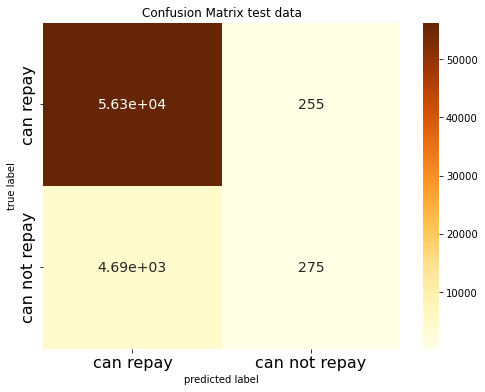

In [108]:
# Evaluate model with best parameters on X_test using predict to calculate precision, recall and f1 score
y_pred_binary = gs_lgbm.predict(X_test)

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred_binary))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_binary)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (8,6))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
             ylabel = 'true label',
             title = 'Confusion Matrix test data')

In [110]:
# Without SMOTE
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
import collections

# Create pipeline (imbpipeline) with smote, scaler and classifier steps
# imbpipeline automatically skip the sampling method (smote) when predict is called
# -> Consequently, there is no data leakage
pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Define param_grid for GridSearchCV
param_grid = {'classifier__n_estimators' : [500],
              'classifier__num_leaves': [50]}

# Create GridSearchCV model
gs_lgbm_nosmote = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = 'roc_auc',
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)

startTime = time.time()
gs_lgbm_nosmote.fit(X, y)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Execution time in minutes: ' + str(executionTime / 60))

cv_score_lgbm_nosmote = gs_lgbm_nosmote.best_score_
print('cv_score_lgbm_nosmote:', cv_score_lgbm_nosmote)

cv_results_lgbm_nosmote = gs_lgbm_nosmote.cv_results_
df_lgbmc_nosmote = pd.DataFrame(cv_results_lgbm_nosmote)
df_lgbmc_nosmote

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__n_estimators=500, classifier__num_leaves=50;, score=(train=0.974, test=0.775) total time= 2.4min
[CV 2/5] END classifier__n_estimators=500, classifier__num_leaves=50;, score=(train=0.972, test=0.776) total time= 1.7min
[CV 3/5] END classifier__n_estimators=500, classifier__num_leaves=50;, score=(train=0.973, test=0.775) total time= 1.3min
[CV 4/5] END classifier__n_estimators=500, classifier__num_leaves=50;, score=(train=0.972, test=0.770) total time= 1.3min
[CV 5/5] END classifier__n_estimators=500, classifier__num_leaves=50;, score=(train=0.974, test=0.771) total time= 1.2min
Execution time in seconds: 592.7277464866638
Execution time in minutes: 9.87879577477773
cv_score_lgbm_nosmote: 0.7731350577713559


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__num_leaves,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,94.241932,25.16736,1.628635,0.160443,500,50,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 50}",0.774763,0.775686,0.774952,0.769568,0.770706,0.773135,0.002493,1,0.974429,0.972027,0.973428,0.971909,0.974448,0.973248,0.001109


In [123]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import collections

# Train_test_split 80/20 with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)

# Create pipeline (imbpipeline) with smote, scaler and classifier steps
# imbpipeline automatically skip the sampling method (smote) when predict is called
# -> Consequently, there is no data leakage
pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Define param_grid for GridSearchCV
param_grid = {'smote__sampling_strategy' : [1],
              'classifier__n_estimators' : [500],
              'classifier__num_leaves': [50]}

# Create GridSearchCV model
gs_lgbm = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = 'roc_auc',
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)

startTime = time.time()
gs_lgbm.fit(X_train, y_train)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Execution time in minutes: ' + str(executionTime / 60))

cv_score_lgbm_split = gs_lgbm.best_score_
print('cv_score_lgbm:', cv_score_lgbm_split)

cv_score_lgbm_split = gs_lgbm.cv_results_
df_lgbmc_split = pd.DataFrame(cv_score_lgbm_split)
df_lgbmc_split

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__n_estimators=500, classifier__num_leaves=50, smote__sampling_strategy=1;, score=(train=0.978, test=0.764) total time= 1.5min
[CV 2/5] END classifier__n_estimators=500, classifier__num_leaves=50, smote__sampling_strategy=1;, score=(train=0.978, test=0.762) total time= 1.3min
[CV 3/5] END classifier__n_estimators=500, classifier__num_leaves=50, smote__sampling_strategy=1;, score=(train=0.977, test=0.767) total time= 1.4min
[CV 4/5] END classifier__n_estimators=500, classifier__num_leaves=50, smote__sampling_strategy=1;, score=(train=0.977, test=0.770) total time= 1.4min
[CV 5/5] END classifier__n_estimators=500, classifier__num_leaves=50, smote__sampling_strategy=1;, score=(train=0.976, test=0.770) total time= 1.4min
Execution time in seconds: 544.1259362697601
Execution time in minutes: 9.068765604496003
cv_score_lgbm: 0.7667568611401436


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__num_leaves,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,83.841846,4.374064,0.862647,0.035596,500,50,1,"{'classifier__n_estimators': 500, 'classifier__num_leaves': 50, 'smote__sampling_strategy': 1}",0.76389,0.762356,0.767387,0.769783,0.770368,0.766757,0.003168,1,0.978311,0.977937,0.977408,0.976799,0.976158,0.977323,0.000773


In [124]:
# Evaluate model with best parameters on X_test using predict_proba to calculate AUC
y_pred = gs_lgbm.predict_proba(X_test)[:,1]

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_test, y_pred))
print('----------------')

roc_auc_score = 0.7728170918060041
----------------


classification_report :
 
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     56537
         1.0       0.48      0.06      0.10      4965

    accuracy                           0.92     61502
   macro avg       0.70      0.53      0.53     61502
weighted avg       0.89      0.92      0.89     61502



[Text(0.5, 33.0, 'predicted label'),
 Text(51.0, 0.5, 'true label'),
 Text(0.5, 1.0, 'Confusion Matrix test data')]

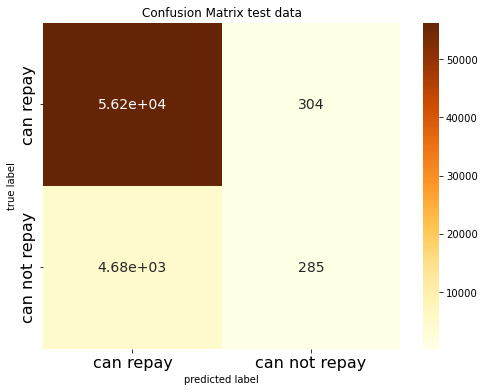

In [125]:
# Evaluate model with best parameters on X_test using predict to calculate precision, recall and f1 score
y_pred_binary = gs_lgbm.predict(X_test)

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred_binary))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_binary)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (8,6))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
             ylabel = 'true label',
             title = 'Confusion Matrix test data')

In [115]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm_noopt(df, num_folds, stratified = False, debug= False):

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 1001)
    else:
        folds = KFold(n_splits = num_folds, shuffle = True, random_state = 1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters
        clf = LGBMClassifier(n_estimators = 1000)

        clf.fit(train_x, train_y, eval_set = [(train_x, train_y), (valid_x, valid_y)], 
            eval_metric = 'auc', verbose = 200, early_stopping_rounds = 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # plot feature importance
    display_importances(feature_importance_df)
    return feature_importance_df

### Logistic Regression

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LogisticRegression()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy' : [0.25, 0.5, 1],
              'classifier__C' : [0.1, 1, 10],
              'classifier__solver' : ['lbfgs'],
              'classifier__max_iter' : [1000, 5000]}

gs_lr = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
gs_lr.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score_lr = gs_lr.best_score_
print('cv_score_lr:', cv_score_lr)

cv_results_lr = gs_lr.cv_results_
df_lr = pd.DataFrame(cv_results_lr)
df_lr

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END classifier__C=0.1, classifier__max_iter=1000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.773, test=0.764) total time= 2.1min
[CV 2/5] END classifier__C=0.1, classifier__max_iter=1000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.775, test=0.758) total time= 1.6min
[CV 3/5] END classifier__C=0.1, classifier__max_iter=1000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.773, test=0.767) total time= 2.0min
[CV 4/5] END classifier__C=0.1, classifier__max_iter=1000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.772, test=0.771) total time= 3.0min
[CV 5/5] END classifier__C=0.1, classifier__max_iter=1000, classifier__solver=lbfgs, smote__sampling_strategy=0.25;, score=(train=0.773, test=0.768) total time= 2.2min
[CV 1/5] END classifier__C=0.1, classifier__max_iter=1000, classifier__solver=lbfgs, smote__samplin

KeyboardInterrupt: 

In [113]:
# Without SMOTE on X and y
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LogisticRegression()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'classifier__C' : [1],
              'classifier__solver' : ['lbfgs'],
              'classifier__max_iter' : [1000]}

gs_lr_nosmote = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
gs_lr_nosmote.fit(X, y)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score_lr_nosmote = gs_lr_nosmote.best_score_
print('cv_score_lr_nosmote:', cv_score_lr_nosmote)

cv_results_lr_nosmote = gs_lr_nosmote.cv_results_
df_lr_nosmote = pd.DataFrame(cv_results_lr_nosmote)
df_lr_nosmote

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs;, score=(train=0.773, test=0.768) total time= 2.6min
[CV 2/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs;, score=(train=0.773, test=0.769) total time= 2.9min
[CV 3/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs;, score=(train=0.774, test=0.768) total time= 2.5min
[CV 4/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs;, score=(train=0.774, test=0.767) total time= 3.0min
[CV 5/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs;, score=(train=0.774, test=0.766) total time= 2.7min
Execution time in seconds: 1076.7124409675598
Execution time in minutes: 17.94520734945933
cv_score_lr_nosmote: 0.7676401492946174


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,163.596861,11.236769,0.598293,0.090444,1,1000,lbfgs,"{'classifier__C': 1, 'classifier__max_iter': 1000, 'classifier__solver': 'lbfgs'}",0.76837,0.768809,0.768117,0.767209,0.765695,0.76764,0.001104,1,0.773302,0.773151,0.773545,0.77366,0.77412,0.773556,0.000334


In [114]:
# Without SMOTE on X_train and y_train
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

pipeline = Pipeline(steps = [['scaler', StandardScaler()],
                             ['classifier', LogisticRegression()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'classifier__C' : [1],
              'classifier__solver' : ['lbfgs'],
              'classifier__max_iter' : [1000]}

gs_lr_nosmote = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
gs_lr_nosmote.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score_lr_nosmote = gs_lr_nosmote.best_score_
print('cv_score_lr_nosmote:', cv_score_lr_nosmote)

cv_results_lr_nosmote = gs_lr_nosmote.cv_results_
df_lr_nosmote = pd.DataFrame(cv_results_lr_nosmote)
df_lr_nosmote

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs;, score=(train=0.774, test=0.765) total time= 2.3min
[CV 2/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs;, score=(train=0.775, test=0.758) total time= 1.5min
[CV 3/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs;, score=(train=0.774, test=0.768) total time= 1.6min
[CV 4/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs;, score=(train=0.772, test=0.772) total time= 1.6min
[CV 5/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs;, score=(train=0.773, test=0.769) total time= 1.4min
Execution time in seconds: 643.7809603214264
Execution time in minutes: 10.729682672023774
cv_score_lr_nosmote: 0.7663652521151343


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,100.698241,18.378486,0.31871,0.031994,1,1000,lbfgs,"{'classifier__C': 1, 'classifier__max_iter': 1000, 'classifier__solver': 'lbfgs'}",0.765013,0.758399,0.767535,0.771968,0.76891,0.766365,0.004572,1,0.77422,0.775352,0.773606,0.772409,0.773285,0.773774,0.000982


In [118]:
# Evaluate model with best parameters on X_test
y_pred = gs_lr_nosmote.predict_proba(X_test)[:,1]

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_test, y_pred))
print('----------------')

roc_auc_score = 0.7691044699207842
----------------


classification_report :
 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.53      0.03      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.73      0.51      0.51     61502
weighted avg       0.89      0.92      0.88     61502



[Text(0.5, 33.0, 'predicted label'),
 Text(51.0, 0.5, 'true label'),
 Text(0.5, 1.0, 'Confusion Matrix test data')]

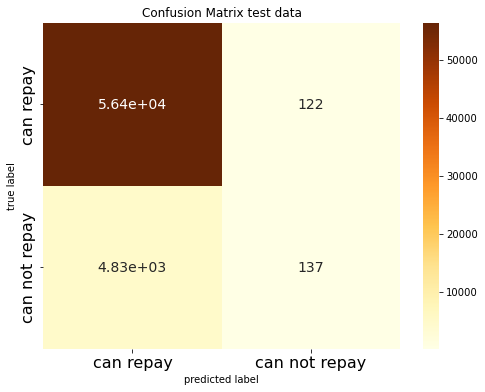

In [119]:
# Evaluate model with best parameters on X_test
y_pred = gs_lr_nosmote.predict(X_test)

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (8,6))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
            ylabel = 'true label',
            title = 'Confusion Matrix test data')

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LogisticRegression()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy' : [1],
              'classifier__C' : [1],
              'classifier__solver' : ['lbfgs'],
              'classifier__max_iter' : [1000]}

gs_lr_smote = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
gs_lr_smote.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score_lr_smote = gs_lr_smote.best_score_
print('cv_score_lr:', cv_score_lr_smote)

cv_results_lr_smote = gs_lr_smote.cv_results_
df_lr_smote = pd.DataFrame(cv_results_lr_smote)
df_lr_smote

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs, smote__sampling_strategy=1;, score=(train=0.773, test=0.764) total time= 4.0min
[CV 2/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs, smote__sampling_strategy=1;, score=(train=0.774, test=0.757) total time= 3.9min
[CV 3/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs, smote__sampling_strategy=1;, score=(train=0.773, test=0.767) total time= 3.8min
[CV 4/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs, smote__sampling_strategy=1;, score=(train=0.771, test=0.771) total time= 3.9min
[CV 5/5] END classifier__C=1, classifier__max_iter=1000, classifier__solver=lbfgs, smote__sampling_strategy=1;, score=(train=0.772, test=0.768) total time= 4.3min
Execution time in seconds: 1521.027200460434
Execution time in minutes: 25.35045334100723
cv_score_lr: 0.7653771485409696


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__solver,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,238.285234,10.07973,0.472794,0.030021,1,1000,lbfgs,1,"{'classifier__C': 1, 'classifier__max_iter': 1000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 1}",0.764238,0.75709,0.76705,0.770724,0.767784,0.765377,0.004629,1,0.773327,0.774295,0.772794,0.771241,0.772268,0.772785,0.001022


In [127]:
# Evaluate model with best parameters on X_test
y_pred = gs_lr_smote.predict_proba(X_test)[:,1]

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_test, y_pred))
print('----------------')

roc_auc_score = 0.768679089227828
----------------


classification_report :
 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.51      0.03      0.05      4965

    accuracy                           0.92     61502
   macro avg       0.72      0.51      0.51     61502
weighted avg       0.89      0.92      0.88     61502



[Text(0.5, 24.0, 'predicted label'),
 Text(33.0, 0.5, 'true label'),
 Text(0.5, 1.0, 'Confusion Matrix test data')]

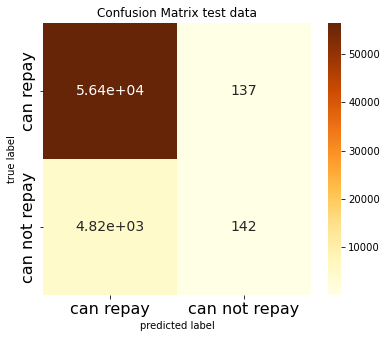

In [129]:
# Evaluate model with best parameters on X_test
y_pred = gs_lr_smote.predict(X_test)

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (6,5))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
            ylabel = 'true label',
            title = 'Confusion Matrix test data')

In [76]:
# Define true positives, false positives, false negatives and true negatives
TP = conf_mat[0][0]
FP = conf_mat[0][1]
FN = conf_mat[1][0]
TN = conf_mat[1][1]

# Define business cost function
cost = 10 * FN + FP

### Gaussian Naive Bayes

In [121]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', GaussianNB()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy' : [0.25, 0.5, 1],
              'classifier__var_smoothing' : [1e-10, 1e-9, 1e-8]}

gs_nb = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
gs_nb.fit(X, y)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score_nb = gs_nb.best_score_
print('cv_score_lr:', cv_score_nb)

cv_results_nb = gs_nb.cv_results_
df_nb = pd.DataFrame(cv_results_nb)
df_nb

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END classifier__var_smoothing=1e-10, smote__sampling_strategy=0.25;, score=(train=0.530, test=0.530) total time=  32.6s
[CV 2/5] END classifier__var_smoothing=1e-10, smote__sampling_strategy=0.25;, score=(train=0.531, test=0.528) total time=  28.5s
[CV 3/5] END classifier__var_smoothing=1e-10, smote__sampling_strategy=0.25;, score=(train=0.531, test=0.527) total time=  29.5s
[CV 4/5] END classifier__var_smoothing=1e-10, smote__sampling_strategy=0.25;, score=(train=0.531, test=0.524) total time=  29.3s
[CV 5/5] END classifier__var_smoothing=1e-10, smote__sampling_strategy=0.25;, score=(train=0.531, test=0.532) total time=  33.0s
[CV 1/5] END classifier__var_smoothing=1e-10, smote__sampling_strategy=0.5;, score=(train=0.531, test=0.531) total time=  32.8s
[CV 2/5] END classifier__var_smoothing=1e-10, smote__sampling_strategy=0.5;, score=(train=0.531, test=0.529) total time=  33.9s
[CV 3/5] END classifier__var_smoothing=

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__var_smoothing,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,29.542884,1.751076,1.165426,0.223057,0.0,0.25,"{'classifier__var_smoothing': 1e-10, 'smote__sampling_strategy': 0.25}",0.529743,0.528115,0.527000,0.523511,0.531563,0.527986,0.002716,6,0.529697,0.531089,0.530544,0.530520,0.530577,0.530486,0.000447
1,31.679370,1.557167,1.220369,0.134651,0.0,0.5,"{'classifier__var_smoothing': 1e-10, 'smote__sampling_strategy': 0.5}",0.531387,0.528784,0.528729,0.522529,0.536513,0.529588,0.004525,5,0.531283,0.531367,0.530981,0.532109,0.530923,0.531332,0.000424
2,44.783925,4.592491,1.441373,0.073133,0.0,1,"{'classifier__var_smoothing': 1e-10, 'smote__sampling_strategy': 1}",0.527925,0.522573,0.520869,0.521779,0.533168,0.525263,0.004653,9,0.527182,0.527379,0.527799,0.528207,0.525987,0.527311,0.000750
3,25.504206,1.120828,1.110065,0.052439,0.0,0.25,"{'classifier__var_smoothing': 1e-09, 'smote__sampling_strategy': 0.25}",0.532245,0.528900,0.527956,0.525329,0.534369,0.529760,0.003195,4,0.530596,0.532697,0.531385,0.531917,0.532067,0.531732,0.000706
4,27.377073,0.557480,1.094078,0.037892,0.0,0.5,"{'classifier__var_smoothing': 1e-09, 'smote__sampling_strategy': 0.5}",0.531489,0.529800,0.528631,0.522580,0.536396,0.529779,0.004469,3,0.531920,0.531595,0.531728,0.533150,0.531578,0.531994,0.000591
5,38.082590,1.065586,1.595274,0.667945,0.0,1,"{'classifier__var_smoothing': 1e-09, 'smote__sampling_strategy': 1}",0.529030,0.522451,0.521644,0.522114,0.534116,0.525871,0.004932,8,0.527429,0.527795,0.528716,0.528655,0.526227,0.527764,0.000914
6,25.151571,0.886764,1.074035,0.066415,0.0,0.25,"{'classifier__var_smoothing': 1e-08, 'smote__sampling_strategy': 0.25}",0.534600,0.530286,0.529826,0.526204,0.536987,0.531580,0.003795,1,0.531948,0.534733,0.532732,0.533627,0.534015,0.533411,0.000976
7,27.716515,1.361949,1.064037,0.023078,0.0,0.5,"{'classifier__var_smoothing': 1e-08, 'smote__sampling_strategy': 0.5}",0.532922,0.530282,0.529120,0.523191,0.536300,0.530363,0.004354,2,0.532842,0.532842,0.532224,0.533881,0.532517,0.532861,0.000560
8,36.281756,0.904808,1.323155,0.120614,0.0,1,"{'classifier__var_smoothing': 1e-08, 'smote__sampling_strategy': 1}",0.528520,0.523125,0.522471,0.522630,0.534938,0.526337,0.004853,7,0.528136,0.528843,0.529121,0.529118,0.527154,0.528475,0.000752


In [122]:
df_nb.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__var_smoothing,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
6,25.151571,0.886764,1.074035,0.066415,0.0,0.25,"{'classifier__var_smoothing': 1e-08, 'smote__sampling_strategy': 0.25}",0.534600,0.530286,0.529826,0.526204,0.536987,0.531580,0.003795,1,0.531948,0.534733,0.532732,0.533627,0.534015,0.533411,0.000976
7,27.716515,1.361949,1.064037,0.023078,0.0,0.5,"{'classifier__var_smoothing': 1e-08, 'smote__sampling_strategy': 0.5}",0.532922,0.530282,0.529120,0.523191,0.536300,0.530363,0.004354,2,0.532842,0.532842,0.532224,0.533881,0.532517,0.532861,0.000560
4,27.377073,0.557480,1.094078,0.037892,0.0,0.5,"{'classifier__var_smoothing': 1e-09, 'smote__sampling_strategy': 0.5}",0.531489,0.529800,0.528631,0.522580,0.536396,0.529779,0.004469,3,0.531920,0.531595,0.531728,0.533150,0.531578,0.531994,0.000591
3,25.504206,1.120828,1.110065,0.052439,0.0,0.25,"{'classifier__var_smoothing': 1e-09, 'smote__sampling_strategy': 0.25}",0.532245,0.528900,0.527956,0.525329,0.534369,0.529760,0.003195,4,0.530596,0.532697,0.531385,0.531917,0.532067,0.531732,0.000706
1,31.679370,1.557167,1.220369,0.134651,0.0,0.5,"{'classifier__var_smoothing': 1e-10, 'smote__sampling_strategy': 0.5}",0.531387,0.528784,0.528729,0.522529,0.536513,0.529588,0.004525,5,0.531283,0.531367,0.530981,0.532109,0.530923,0.531332,0.000424
0,29.542884,1.751076,1.165426,0.223057,0.0,0.25,"{'classifier__var_smoothing': 1e-10, 'smote__sampling_strategy': 0.25}",0.529743,0.528115,0.527000,0.523511,0.531563,0.527986,0.002716,6,0.529697,0.531089,0.530544,0.530520,0.530577,0.530486,0.000447
8,36.281756,0.904808,1.323155,0.120614,0.0,1,"{'classifier__var_smoothing': 1e-08, 'smote__sampling_strategy': 1}",0.528520,0.523125,0.522471,0.522630,0.534938,0.526337,0.004853,7,0.528136,0.528843,0.529121,0.529118,0.527154,0.528475,0.000752
5,38.082590,1.065586,1.595274,0.667945,0.0,1,"{'classifier__var_smoothing': 1e-09, 'smote__sampling_strategy': 1}",0.529030,0.522451,0.521644,0.522114,0.534116,0.525871,0.004932,8,0.527429,0.527795,0.528716,0.528655,0.526227,0.527764,0.000914
2,44.783925,4.592491,1.441373,0.073133,0.0,1,"{'classifier__var_smoothing': 1e-10, 'smote__sampling_strategy': 1}",0.527925,0.522573,0.520869,0.521779,0.533168,0.525263,0.004653,9,0.527182,0.527379,0.527799,0.528207,0.525987,0.527311,0.000750


In [130]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', GaussianNB()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy' : [0.25],
              'classifier__var_smoothing' : [1e-8]}

gs_nb_split = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
gs_nb_split.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score_nb_split = gs_nb_split.best_score_
print('cv_score_lr:', cv_score_nb_split)

cv_results_nb_split = gs_nb_split.cv_results_
df_nb_split = pd.DataFrame(cv_results_nb_split)
df_nb_split

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__var_smoothing=1e-08, smote__sampling_strategy=0.25;, score=(train=0.531, test=0.524) total time=  24.3s
[CV 2/5] END classifier__var_smoothing=1e-08, smote__sampling_strategy=0.25;, score=(train=0.533, test=0.521) total time=  21.2s
[CV 3/5] END classifier__var_smoothing=1e-08, smote__sampling_strategy=0.25;, score=(train=0.532, test=0.529) total time=  22.4s
[CV 4/5] END classifier__var_smoothing=1e-08, smote__sampling_strategy=0.25;, score=(train=0.529, test=0.536) total time=  19.5s
[CV 5/5] END classifier__var_smoothing=1e-08, smote__sampling_strategy=0.25;, score=(train=0.532, test=0.532) total time=  20.5s
Execution time in seconds: 148.930837392807
Execution time in minutes: 2.4821806232134502
cv_score_lr: 0.5283880717833875


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__var_smoothing,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,20.764703,1.669167,0.905583,0.059361,0.0,0.25,"{'classifier__var_smoothing': 1e-08, 'smote__sampling_strategy': 0.25}",0.523613,0.521067,0.529458,0.535721,0.532082,0.528388,0.005384,1,0.531176,0.532868,0.532418,0.529313,0.531509,0.531457,0.001232


In [131]:
# Evaluate model with best parameters on X_test
y_pred = gs_nb_split.predict_proba(X_test)[:,1]

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_test, y_pred))
print('----------------')

roc_auc_score = 0.5314039317370987
----------------


classification_report :
 
              precision    recall  f1-score   support

         0.0       0.94      0.18      0.31     56537
         1.0       0.09      0.87      0.16      4965

    accuracy                           0.24     61502
   macro avg       0.51      0.53      0.23     61502
weighted avg       0.87      0.24      0.29     61502



[Text(0.5, 24.0, 'predicted label'),
 Text(33.0, 0.5, 'true label'),
 Text(0.5, 1.0, 'Confusion Matrix test data')]

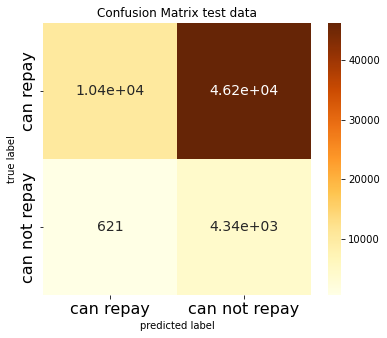

In [132]:
# Evaluate model with best parameters on X_test
y_pred = gs_nb_split.predict(X_test)

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (6,5))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
            ylabel = 'true label',
            title = 'Confusion Matrix test data')

### AdaBoost classifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', AdaBoostClassifier()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy': [1],
              'classifier__n_estimators': [100],
              'classifier__learning_rate': [1]}

gs_adaboost = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
gs_adaboost.fit(X, y)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score_adaboost = gs_adaboost.best_score_
print('cv_score_adaboost:', cv_score_adaboost)

cv_results_adaboost = gs_adaboost.cv_results_
df_nb_adaboost = pd.DataFrame(cv_results_adaboost)
df_nb_adaboost

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__learning_rate=1, classifier__n_estimators=100, smote__sampling_strategy=1;, score=(train=0.699, test=0.694) total time=18.3min
[CV 2/5] END classifier__learning_rate=1, classifier__n_estimators=100, smote__sampling_strategy=1;, score=(train=0.699, test=0.699) total time=17.8min
[CV 3/5] END classifier__learning_rate=1, classifier__n_estimators=100, smote__sampling_strategy=1;, score=(train=0.696, test=0.694) total time=17.7min
[CV 4/5] END classifier__learning_rate=1, classifier__n_estimators=100, smote__sampling_strategy=1;, score=(train=0.699, test=0.694) total time=17.7min
[CV 5/5] END classifier__learning_rate=1, classifier__n_estimators=100, smote__sampling_strategy=1;, score=(train=0.702, test=0.704) total time=71.1min


### MLPClassifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

pipeline = Pipeline(steps = [['smote', SMOTE(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', MLPClassifier()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy': [1]}

gs_mlpc = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
gs_mlpc.fit(X, y)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score_mlpc = gs_mlpc.best_score_
print('cv_score_mlpc:', cv_score_mlpc)

cv_results_mlpc = gs_mlpc.cv_results_
df_nb_mlpc = pd.DataFrame(cv_results_mlpc)
df_nb_mlpc

In [73]:
from sklearn.neural_network import MLPClassifier

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

mlpc = MLPClassifier()

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)
    
param_grid = {}

grid_search = GridSearchCV(estimator=mlpc,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold)

grid_search.fit(X_train_scaled, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Cross-validation score: {cv_score}')
print(f'best_params: {best_params}')

Cross-validation score: 0.7280236282474135
best_params: {}


### RandomForestClassifier

In [100]:
from sklearn.ensemble import RandomForestClassifier

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

rfc = RandomForestClassifier()

stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

param_grid = {}

grid_search = GridSearchCV(estimator=rfc,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold)

grid_search.fit(X_train_scaled, y_train)
cv_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f'Cross-validation score: {cv_score}')
print(f'best_params: {best_params}')

Cross-validation score: 0.7181763254974084
best_params: {}


In [101]:
## Import Modules
import numpy as np
import pandas as pd
import os
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFECV
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

In [102]:
df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

In [105]:
## Scaling
scaler = preprocessing.StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)

columns = X_train.columns

## Over-sampling training data using SMOTE
os = SMOTE(sampling_strategy = 0.3, random_state=0)
os_X_train, os_y_train = os.fit_resample(X_train_scaled, y_train)
X_train_scaled

os_data_X = pd.DataFrame(data=os_X_train,columns=columns)
os_data_y = pd.DataFrame(data=os_y_train,columns=['y'])

# Oversampling report
print("\nBalancing data with synthetic data..")
print("\nLength of synthetic training data:",(len(os_data_X) - len(X_train)))
print("Length of original training data:",len(X_train))
print("Length of oversampled training data:",len(os_data_X))
print("Proportion of negative examples in original data:", round(len(y_train[y_train==1])/len(y_train), 3))
print("Proportion of negative examples in oversampled data:",len(os_data_y[os_data_y['y']==1])/len(os_data_X))


Balancing data with synthetic data..

Length of synthetic training data: 59979
Length of original training data: 307507
Length of oversampled training data: 367486
Proportion of negative examples in original data: 0.081
Proportion of negative examples in oversampled data: 0.23076797483441547


In [107]:
# Set the parameters by cross-validation
param_grid = {'C' : [0.05, 0.1, 0.2],
              'solver' : ['newton-cg']}

## Add different measures for optimisation
scores = ['accuracy', 'roc_auc', 'f1', 'recall', 'precision']

### Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits=5,
                                   shuffle=True,
                                   random_state=11)

In [108]:
### Fitting Models

for score in scores:
    
    print("Tuning hyper-parameters for %s ..." % score)
    print()
    lr = LogisticRegression(random_state=11)
    clf_lr = GridSearchCV(lr,
                          param_grid, 
                          cv = stratified_kfold,
                          scoring = score)
    grid = clf_lr.fit(os_data_X, np.ravel(os_data_y))
    print("GridSearchCV Grid scores on development set (not on test set):")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)

Tuning hyper-parameters for accuracy ...

GridSearchCV Grid scores on development set (not on test set):

0.785 (+/-0.002) for {'C': 0.05, 'solver': 'newton-cg'}
0.785 (+/-0.002) for {'C': 0.1, 'solver': 'newton-cg'}
0.785 (+/-0.001) for {'C': 0.2, 'solver': 'newton-cg'}

Best parameters set found on development set:

{'C': 0.2, 'solver': 'newton-cg'}
Tuning hyper-parameters for roc_auc ...

GridSearchCV Grid scores on development set (not on test set):

0.769 (+/-0.002) for {'C': 0.05, 'solver': 'newton-cg'}
0.769 (+/-0.002) for {'C': 0.1, 'solver': 'newton-cg'}
0.769 (+/-0.002) for {'C': 0.2, 'solver': 'newton-cg'}

Best parameters set found on development set:

{'C': 0.2, 'solver': 'newton-cg'}
Tuning hyper-parameters for f1 ...



KeyboardInterrupt: 

In [123]:
# Code to display all columns and all texts
def set_pandas_display_options() -> None:
    display = pd.options.display
    display.max_columns = 20
    display.max_rows = 100
    display.max_colwidth = 300
    display.width = None
set_pandas_display_options()

In [125]:
df.sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__max_iter,param_classifier__solver,param_smote__sampling_strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
28,15.886906,0.782118,0.074401,0.009369,0.5,5000,lbfgs,0.25,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744403,0.743811,0.749844,0.744626,0.744637,0.745464,0.002210,1
24,33.430920,0.932554,0.072407,0.003919,0.5,5000,newton-cg,0.25,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744405,0.743813,0.749838,0.744625,0.744639,0.745464,0.002208,2
20,15.285660,0.322102,0.081986,0.009589,0.2,5000,lbfgs,0.25,"{'classifier__C': 0.2, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744398,0.743814,0.749834,0.744637,0.744619,0.745460,0.002207,3
16,28.959747,2.737443,0.073207,0.004829,0.2,5000,newton-cg,0.25,"{'classifier__C': 0.2, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744398,0.743813,0.749831,0.744633,0.744619,0.745459,0.002206,4
12,14.814398,0.303162,0.077194,0.010827,0.1,5000,lbfgs,0.25,"{'classifier__C': 0.1, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744384,0.743808,0.749820,0.744636,0.744595,0.745448,0.002206,5
8,26.038755,2.303059,0.070422,0.003005,0.1,5000,newton-cg,0.25,"{'classifier__C': 0.1, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744383,0.743810,0.749817,0.744635,0.744592,0.745448,0.002205,6
4,14.260972,0.192017,0.069414,0.003867,0.05,5000,lbfgs,0.25,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.25}",0.744353,0.743804,0.749791,0.744625,0.744558,0.745426,0.002201,7
0,42.397745,36.477739,0.099733,0.054906,0.05,5000,newton-cg,0.25,"{'classifier__C': 0.05, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.25}",0.744355,0.743803,0.749791,0.744623,0.744556,0.745426,0.002201,8
29,17.774251,0.800099,0.071210,0.003868,0.5,5000,lbfgs,0.5,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'lbfgs', 'smote__sampling_strategy': 0.5}",0.741856,0.740762,0.747003,0.742043,0.741975,0.742728,0.002188,9
25,38.023408,2.543100,0.073798,0.004850,0.5,5000,newton-cg,0.5,"{'classifier__C': 0.5, 'classifier__max_iter': 5000, 'classifier__solver': 'newton-cg', 'smote__sampling_strategy': 0.5}",0.741857,0.740767,0.746997,0.742038,0.741979,0.742728,0.002185,10


In [ ]:
# Define true positives, false positives, false negatives and true negatives
TP = conf_mat[0][0]
FP = conf_mat[0][1]
FN = conf_mat[1][0]
TN = conf_mat[1][1]

# Define business cost function
cost = 10 * FN + FP

In [134]:
from collections import Counter
from imblearn.over_sampling import SMOTE

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values
                        
print('Original dataset shape %s' % Counter(y_train))

sm = SMOTE(sampling_strategy = 0.25,
            random_state=42)

startFitTime = time.time()

X_res, y_res = sm.fit_resample(X_train, y_train)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 282682, 1.0: 24825})
Execution time in seconds: 11.922111749649048
Execution time in minutes: 0.1987018624941508
Resampled dataset shape Counter({0.0: 282682, 1.0: 70670})


In [136]:
from collections import Counter
from imblearn.over_sampling import ADASYN

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values
                        
print('Original dataset shape %s' % Counter(y_train))

adasyn = ADASYN(sampling_strategy = 0.25,
                random_state=42)

startFitTime = time.time()

X_res, y_res = adasyn.fit_resample(X_train, y_train)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 282682, 1.0: 24825})
Execution time in seconds: 142.3265814781189
Execution time in minutes: 2.3721096913019815
Resampled dataset shape Counter({0.0: 282682, 1.0: 71946})


In [137]:
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values
                        
print('Original dataset shape %s' % Counter(y_train))

bordersm = BorderlineSMOTE(sampling_strategy = 0.25,
                           random_state=42)

startFitTime = time.time()

X_res, y_res = bordersm.fit_resample(X_train, y_train)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 282682, 1.0: 24825})
Execution time in seconds: 138.6216516494751
Execution time in minutes: 2.310360860824585
Resampled dataset shape Counter({0.0: 282682, 1.0: 70670})


In [ ]:
from collections import Counter
from imblearn.over_sampling import SVMSMOTE

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values
                        
print('Original dataset shape %s' % Counter(y_train))

svmsm = SVMSMOTE(sampling_strategy = 0.25,
                 random_state=42)

startFitTime = time.time()

X_res, y_res = svmsm.fit_resample(X_train, y_train)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 282682, 1.0: 24825})


In [131]:
from collections import Counter
from imblearn.combine import SMOTEENN 

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values
                        
print('Original dataset shape %s' % Counter(y_train))

sme = SMOTEENN(sampling_strategy = 0.25, 
               random_state=42)

startFitTime = time.time()

X_res, y_res = sme.fit_resample(X_train, y_train)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 282682, 1.0: 24825})
Resampled dataset shape Counter({0.0: 199815, 1.0: 44558})


In [135]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.combine import SMOTETomek 

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values
                        
print('Original dataset shape %s' % Counter(y_train))

smt = SMOTETomek(sampling_strategy = 0.25, 
                 random_state=42)

startFitTime = time.time()

X_res, y_res = smt.fit_resample(X_train, y_train)

executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0.0: 282682, 1.0: 24825})
Execution time in seconds: 1511.8728518486023
Execution time in minutes: 25.19788086414337
Resampled dataset shape Counter({0.0: 280748, 1.0: 68736})


In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

df_nan40_best_feat_100_train = df_nan40_best_feat_100[df_nan40_best_feat_100['TARGET'].notnull()]

X_train = df_nan40_best_feat_100_train.drop(['index', 'SK_ID_CURR', 'TARGET'], axis = 1) 
y_train = df_nan40_best_feat_100_train['TARGET'].values

pipeline = Pipeline(steps = [['smote', SMOTEENN(random_state = 11)],
                             ['scaler', StandardScaler()],
                             ['classifier', LogisticRegression()]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'smote__sampling_strategy' : [0.25, 0.5, 0.75, 1],
              'classifier__C' : [0.05, 0.1, 0.2, 0.5],
              'classifier__solver' : ['newton-cg', 'lbfgs'],
              'classifier__max_iter' : [5000]}

grid_search = GridSearchCV(estimator = pipeline,
                           param_grid = param_grid,
                           scoring = 'roc_auc',
                           cv = stratified_kfold,
                           verbose = 5,
                           return_train_score = True)

startFitTime = time.time()
grid_search.fit(X_train, y_train)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score = grid_search.best_score_
print('cv_score:', cv_score)

cv_results = grid_search.cv_results_
df = pd.DataFrame(cv_results)
df

In [28]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import collections

# Train_test_split 80/20 with stratify
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 42)

In [29]:
y_test.shape

(61502,)

In [30]:
X_train.shape

(246005, 551)

In [31]:
y_train.shape

(246005,)

In [72]:
# Create pipeline (imbpipeline) with smote, scaler and classifier steps
# imbpipeline automatically skip the sampling method (smote) when predict is called
# -> Consequently, there is no data leakage
pipeline = Pipeline(steps = [['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

# Define param_grid for GridSearchCV
param_grid = {'classifier__n_estimators' : [500]}

# Create GridSearchCV model
gs_lgbm = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = 'roc_auc',
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)

startTime = time.time()
gs_lgbm.fit(X_train, y_train)
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Execution time in minutes: ' + str(executionTime / 60))

cv_score_lgbm_split = gs_lgbm.best_score_
print('cv_score_lgbm:', cv_score_lgbm_split)

cv_score_lgbm_split = gs_lgbm.cv_results_
df_lgbmc_split = pd.DataFrame(cv_score_lgbm_split)
df_lgbmc_split

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__n_estimators=500;, score=(train=0.953, test=0.769) total time=  38.4s
[CV 2/5] END classifier__n_estimators=500;, score=(train=0.953, test=0.766) total time=  28.5s
[CV 3/5] END classifier__n_estimators=500;, score=(train=0.952, test=0.774) total time=  27.2s
[CV 4/5] END classifier__n_estimators=500;, score=(train=0.952, test=0.774) total time=  25.7s
[CV 5/5] END classifier__n_estimators=500;, score=(train=0.953, test=0.778) total time=  29.3s
Execution time in seconds: 191.91669178009033
Execution time in minutes: 3.198611529668172
cv_score_lgbm: 0.7721773444868685


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,29.243915,4.437362,0.66401,0.052731,500,{'classifier__n_estimators': 500},0.768811,0.76631,0.774174,0.773998,...,0.772177,0.004059,1,0.952606,0.952678,0.951739,0.951729,0.953244,0.952399,0.000587


In [73]:
from sklearn.metrics import roc_auc_score
# Evaluate model with best parameters on X_test using predict_proba to calculate AUC
y_pred = gs_lgbm.predict_proba(X_test)[:,1]

# Calculate and print roc_auc score
print('roc_auc_score =', roc_auc_score(y_test, y_pred))
print('----------------')

roc_auc_score = 0.7770865841743685
----------------


classification_report :
 
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56537
         1.0       0.55      0.05      0.10      4965

    accuracy                           0.92     61502
   macro avg       0.74      0.52      0.53     61502
weighted avg       0.89      0.92      0.89     61502



[Text(0.5, 33.0, 'predicted label'),
 Text(51.0, 0.5, 'true label'),
 Text(0.5, 1.0, 'Confusion Matrix test data')]

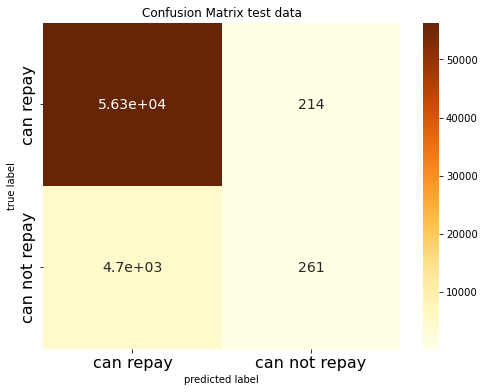

In [74]:
# Evaluate model with best parameters on X_test using predict to calculate precision, recall and f1 score
y_pred_binary = gs_lgbm.predict(X_test)

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred_binary))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_binary)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (8,6))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
             ylabel = 'true label',
             title = 'Confusion Matrix test data')

classification_report :
 
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96     56537
         1.0       0.53      0.63      0.57      4965

    accuracy                           0.92     61502
   macro avg       0.75      0.79      0.77     61502
weighted avg       0.93      0.92      0.93     61502



[Text(0.5, 33.0, 'predicted label'),
 Text(51.0, 0.5, 'true label'),
 Text(0.5, 1.0, 'Confusion Matrix test data')]

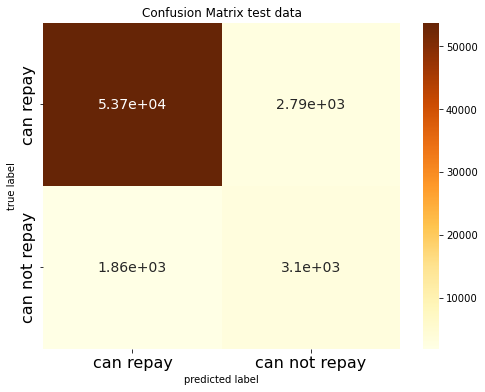

In [104]:
# Evaluate model with best parameters on X_test using predict to calculate precision, recall and f1 score
y_pred_binary_thres = (gs_lgbm.predict_proba(X_test)[:,1] >= 0.2).astype(bool)

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred_binary_thres))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_binary_thres)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (8,6))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
             ylabel = 'true label',
             title = 'Confusion Matrix test data')

classification_report :
 
              precision    recall  f1-score   support

         0.0       0.98      0.82      0.90     56537
         1.0       0.30      0.85      0.44      4965

    accuracy                           0.82     61502
   macro avg       0.64      0.84      0.67     61502
weighted avg       0.93      0.82      0.86     61502



[Text(0.5, 33.0, 'predicted label'),
 Text(51.0, 0.5, 'true label'),
 Text(0.5, 1.0, 'Confusion Matrix test data')]

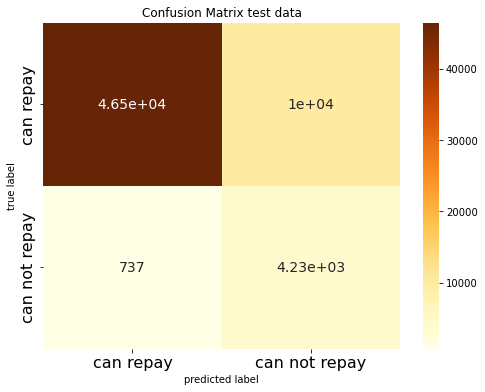

In [105]:
# Evaluate model with best parameters on X_test using predict to calculate precision, recall and f1 score
y_pred_binary_thres = (gs_lgbm.predict_proba(X_test)[:,1] >= 0.1).astype(bool)

# Print classification report with precision, recall and f1-score for each class
from sklearn.metrics import classification_report
print('classification_report :')
print(' ')
print(classification_report(y_test, y_pred_binary_thres))

# Print Confusion Matrix on Test data
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_binary_thres)
data_cm = pd.DataFrame(conf_mat,
                       index = ['can repay', 'can not repay'],
                       columns = ['can repay', 'can not repay'])

plt.figure(figsize = (8,6))
cmap = 'YlOrBr'
colormap = sns.heatmap(data_cm, 
                        annot=True, 
                        annot_kws ={'size':14}, 
                        cmap=cmap, 
                        fmt='.3g')
colormap.set_xticklabels(colormap.get_xmajorticklabels(), size = 16)
colormap.set_yticklabels(colormap.get_ymajorticklabels(), size = 16)
    
colormap.set(xlabel = 'predicted label',
             ylabel = 'true label',
             title = 'Confusion Matrix test data')

In [79]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, det_curve

fpr, fnr, thresholds = det_curve(y_test, y_pred)

In [83]:
fpr

array([9.99204061e-01, 9.99204061e-01, 9.99186374e-01, ...,
       1.76875321e-05, 1.76875321e-05, 0.00000000e+00])

In [82]:
fnr

array([0.00000000e+00, 2.01409869e-04, 2.01409869e-04, ...,
       9.99597180e-01, 9.99798590e-01, 9.99798590e-01])

In [84]:
thresholds

array([0.00214957, 0.00217276, 0.00218024, ..., 0.89833885, 0.90453226,
       0.93136308])

In [85]:
precision, recall, thresholds2 = precision_recall_curve(y_test, y_pred)

In [86]:
precision

array([0.08078819, 0.08077324, 0.08077455, ..., 0.5       , 1.        ,
       1.        ])

In [87]:
recall

array([1.00000000e+00, 9.99798590e-01, 9.99798590e-01, ...,
       2.01409869e-04, 2.01409869e-04, 0.00000000e+00])

In [88]:
thresholds2

array([0.00214957, 0.00217276, 0.00218024, ..., 0.89833885, 0.90453226,
       0.93136308])

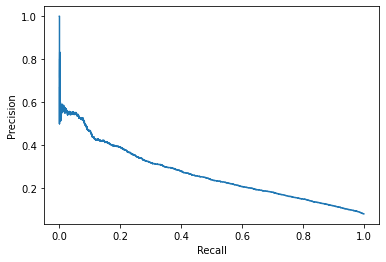

In [89]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
disp = PrecisionRecallDisplay(precision = precision, recall = recall)
disp.plot()
plt.show()

In [94]:
from sklearn.metrics import fbeta_score, recall_score, precision_score, f1_score

fbeta_score(y_test, y_pred_binary, average = 'binary', beta = 2)

0.06417506761740842

In [99]:
print('recall =', recall_score(y_test, y_pred_binary))
print('precision =', precision_score(y_test, y_pred_binary))
print('------------------')
print('f1_score =', fbeta_score(y_test, y_pred_binary, average = 'binary', beta = 1))
print('------------------')
print('f2_score =', fbeta_score(y_test, y_pred_binary, average = 'binary', beta = 2))
print('------------------')
print('f0.5_score =', fbeta_score(y_test, y_pred_binary, average = 'binary', beta = 0.5))
print('------------------')

recall = 0.05256797583081571
precision = 0.5494736842105263
------------------
f1_score = 0.09595588235294118
------------------
f2_score = 0.06417506761740842
------------------
f0.5_score = 0.19009468317552802
------------------


0.05256797583081571

0.5494736842105263

In [75]:
from sklearn.metrics import make_scorer

def business_cost_func(y_true, y_pred):
    # Build confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)    
    # Define true positives, false positives, false negatives and true negatives
    FP = conf_mat[0][1]
    FN = conf_mat[1][0]
    # Define business cost function
    cost = (10 * FN + FP) / y_true.size

    return cost

business_cost_loss = make_scorer(business_cost_func, greater_is_better = False)

In [77]:
cost_loss = business_cost_func(y_test, y_pred_binary)
cost_loss

0.7683327371467594

In [48]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

# Create pipeline (imbpipeline) with smote, scaler and classifier steps
# imbpipeline automatically skip the sampling method (smote) when predict is called
# -> Consequently, there is no data leakage
pipeline = Pipeline(steps = [['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'classifier__n_estimators' : [500]}

gs_lgbm = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = business_cost,
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)

startFitTime = time.time()
gs_lgbm.fit(X, y)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score_lgbm = gs_lgbm.best_score_
print('cv_score_lgbm:', cv_score_lgbm)

cv_results_lgbm = gs_lgbm.cv_results_
df_lgbmc = pd.DataFrame(cv_results_lgbm)
df_lgbmc

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END classifier__n_estimators=500;, score=(train=0.682, test=0.771) total time=  41.2s
[CV 2/5] END classifier__n_estimators=500;, score=(train=0.687, test=0.771) total time=  39.3s
[CV 3/5] END classifier__n_estimators=500;, score=(train=0.683, test=0.776) total time=  35.8s
[CV 4/5] END classifier__n_estimators=500;, score=(train=0.685, test=0.767) total time=  39.4s
[CV 5/5] END classifier__n_estimators=500;, score=(train=0.683, test=0.772) total time=  37.5s
Execution time in seconds: 255.33988571166992
Execution time in minutes: 4.255664761861166
cv_score_lgbm: 0.7715336578748245


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,37.776258,1.786328,0.970662,0.062863,500,{'classifier__n_estimators': 500},0.771227,0.771308,0.775516,0.767142,...,0.771534,0.00269,1,0.681885,0.687124,0.683284,0.68463,0.68328,0.684041,0.001769


In [78]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

# Create pipeline (imbpipeline) with smote, scaler and classifier steps
# imbpipeline automatically skip the sampling method (smote) when predict is called
# -> Consequently, there is no data leakage
pipeline = Pipeline(steps = [['classifier', LGBMClassifier(random_state = 11)]])

# Define stratifiedKfold
stratified_kfold = StratifiedKFold(n_splits = 5,
                                   shuffle = True,
                                   random_state = 11)

param_grid = {'classifier__n_estimators' : [100, 500]}

gs_lgbm = GridSearchCV(estimator = pipeline,
                       param_grid = param_grid,
                       scoring = business_cost_loss,
                       cv = stratified_kfold,
                       verbose = 5,
                       return_train_score = True)

startFitTime = time.time()
gs_lgbm.fit(X, y)
executionFitTime = (time.time() - startFitTime)
print('Execution time in seconds: ' + str(executionFitTime))
print('Execution time in minutes: ' + str(executionFitTime / 60))

cv_score_lgbm = gs_lgbm.best_score_
print('cv_score_lgbm:', cv_score_lgbm)

cv_results_lgbm = gs_lgbm.cv_results_
df_lgbmc = pd.DataFrame(cv_results_lgbm)
df_lgbmc

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END classifier__n_estimators=100;, score=(train=-0.767, test=-0.782) total time=  22.0s
[CV 2/5] END classifier__n_estimators=100;, score=(train=-0.769, test=-0.783) total time=  18.7s
[CV 3/5] END classifier__n_estimators=100;, score=(train=-0.767, test=-0.782) total time=  19.3s
[CV 4/5] END classifier__n_estimators=100;, score=(train=-0.769, test=-0.777) total time=  20.5s
[CV 5/5] END classifier__n_estimators=100;, score=(train=-0.765, test=-0.783) total time=  21.4s
[CV 1/5] END classifier__n_estimators=500;, score=(train=-0.682, test=-0.771) total time=  40.5s
[CV 2/5] END classifier__n_estimators=500;, score=(train=-0.687, test=-0.771) total time=  37.5s
[CV 3/5] END classifier__n_estimators=500;, score=(train=-0.683, test=-0.776) total time=  39.8s
[CV 4/5] END classifier__n_estimators=500;, score=(train=-0.685, test=-0.767) total time=  36.4s
[CV 5/5] END classifier__n_estimators=500;, score=(train=-0.683, te

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,19.724158,1.249534,0.753426,0.061971,100,{'classifier__n_estimators': 100},-0.782040,-0.783275,-0.781987,-0.776622,...,-0.781423,0.002462,2,-0.767098,-0.769151,-0.766741,-0.769396,-0.764506,-0.767378,0.001786
1,37.292613,1.713569,0.935043,0.024742,500,{'classifier__n_estimators': 500},-0.771227,-0.771308,-0.775516,-0.767142,...,-0.771534,0.002690,1,-0.681885,-0.687124,-0.683284,-0.684630,-0.683280,-0.684041,0.001769


In [20]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei